In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

from JUSUFlike.Project.Codes.processing_results import *
from IPython.display import Image
import tvb_model_reference.src.nuu_tools_simulation_human as tools
from sklearn.cluster import KMeans

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

fig_labels = ['$S$', '$b_e$ (pA)', '$E_{L,i}$ (mV)', '$E_{L,e}$ (mV)', '$T$ (ms)']

# Analyzing results Parameter Sweep with steps = 6

### All the metrics obtained
In the following dictionary one can find the strings that identify all the metrics that have been obtained from the simulations. Some of them are quite clear in their name. Others are commented with the objective of giving a bit more insight about them.

In [2]:
dict_params = {'a': 0, 'b_e': 1, 'E_L_i': 2, 'E_L_e': 3, 'T': 4}

dict_metrics = {'mean_FR_e': 5, 'mean_FR_i': 23, 'std_FR_e': 6, 'std_FR_i': 24,
                # Mean of FC and PLI matrices for both FRs
                'mean_FC_e': 7, 'mean_FC_i': 25, 'mean_PLI_e': 8, 'mean_PLI_i': 26,
                # Mean duration of up and down states
                'mean_up_e': 9, 'mean_up_i': 27, 'mean_down_e': 10, 'mean_down_i': 28,
                # all time max and minimum FR over all the regions
                'max_FR_e': 11, 'max_FR_i': 29, 
                # Peaks of PSDs. We obtain the frequency (fmax) at which the peak appears and 
                # its amplitude/power (pmax)
                # The peak has been calculted with two methods: peak with highest amplitude (amp)
                # and peak with highest prominence (prom)
                'fmax_amp_e': 12, 'pmax_amp_e': 13, 'fmax_amp_i': 30, 'pmax_amp_i': 31, 
                'fmax_prom_e': 14, 'pmax_prom_e': 15, 'fmax_prom_i': 32, 'pmax_prom_i': 33, 
                # The PSD has also been fitted to a power law b/f^a. We have obtained the slope a and
                # the score of the fitting.
                'slope_PSD_e': 16, 'score_PSD_e': 17, 'slope_PSD_i': 34, 'score_PSD_i': 35, 
                # frequencies have been divided into 5 typical bands: 'delta': (0.5, 4)Hz, 
                # 'theta': (4, 8)Hz,  'alpha': (8, 12)Hz, 'beta': (12, 30) Hz, 'gamma': (30, 100) Hz
                # and the relative power in each band has been obtained by numerical integration
                'delta_rel_p_e': 18, 'theta_rel_p_e': 19, 'alpha_rel_p_e': 20, 'beta_rel_p_e': 21, 
                'gamma_rel_p_e': 22, 'delta_rel_p_i': 36,'theta_rel_p_i': 37, 'alpha_rel_p_i': 38,
                'beta_rel_p_i': 39, 'gamma_rel_p_i': 40,
                # Finally, scoring on how close the spontaneous dynamics are to the expected dynamics
                # of the DMN has been performed in two ways.
                # 1. zscore: take PCC as seed, obtain correlations with all other regions (zscores),
                # take: the 10 most correlated, count how many of the 10 regions belong to DMN
                # 2. frmean: obtain mean FR over time of each region, take the 10 with highest
                # mean FR, count how many of the 10 regions belong to DMN.
                'ratio_frmean_dmn_exc': 41, 'ratio_zscore_dmn_exc': 42, 'ratio_frmean_dmn_inh': 43,
                'ratio_zscore_dmn_inh': 44, 
                # To be finished, trying to count how many AI or UD nodes are in the 68 regions
                'ratio_AI_exc': 45,
                # Correlation between the FC matrix and the SC/weight matrix.
                'corr_FC_SC_e': 46, 'corr_FC_SC_i': 47,
                # Correlation between the FC matrix and the SC/weight matrix.
                'corr_FC_tract_e': 48, 'corr_FC_tract_i': 49, 
                # Coefficient of variation (std/mean)
                'coeff_var_e': 50, 'coeff_var_i':51,
                # standard deviation of the mean FR in time (so std of a 68 element vector)
                'std_of_means_e': 52, 'std_of_means_i': 53, 
                # Mean of std vector in time (so mean of 68 std element vector)
                'means_of_std_e':54, 'means_of_std_i': 55}

### How to obtain plots of metric values when sweeping two parameters
The way to do this is to fix three parameters to a certain value. We can say what approximate value we want to fix it to and the algorithm will find the closest parameter value in the parameter sweep.
We declare the other two parameters that will be used for the sweep, a list of the metrics that we want to obtain and how many values/parameter have been explored in the parameter sweep (steps).
For instance, we want to see how $b$ and $T$ change when we fix inter-region coupling ($a$) close to 0.4, $E_{Le}$ close to -63mV and $E_{Li}$ close to -65mV.

By changing the metrics list (with the strings in the previous cell) one can select what metrics are shown.

In [ ]:
plt.rcParams.update({'font.size': 14})


figures_folder = './figures/JUSUF/'
batches_folder = './JUSUFlike/Project/FinalResults/'

fixed_params = {'E_L_i': -65, 'E_L_e': -63, 'T': 40}
params_sweep = ('a', 'b_e')

steps = 16
metrics = ['fmax_amp_e', 'mean_FR_e', 'mean_FC_e', 
           'delta_rel_p_e', 'std_FR_e', 'max_FR_e',
          'ratio_zscore_dmn_exc', 'slope_PSD_e', 'mean_up_e']
imshow_ranges = [(0, 15), (0, 10), (0, 1), (0, 1), (0, 4), (0, 175), (None, None), (None, None), (None, None)]
fig = plot_multiple_metrics(metrics, batches_folder, params_sweep, fixed_params, steps, imshow_ranges)
fig.savefig(figures_folder + 'metrics.png')
plt.show()

# Make a movie where changing time corresponds to changing a third parameter

In [ ]:
from IPython.display import Image

fixed_params = {'E_L_e':-63, 'E_L_i':-63}
params_sweep_im = ('a', 'b_e')
param_sweep_time = 'T'

title_movie = 'JUSUF'
for key in fixed_params.keys():
    title_movie += '_' + key + str(fixed_params[key]) 
title_movie += 'frames' + param_sweep_time
print(title_movie)

movies_folder = './figures/JUSUF/movie/'
batches_folder = './JUSUFlike/Project/FinalResults/'

steps = 16
metrics = ['fmax_amp_e', 'mean_FR_e', 'mean_FC_e', 
           'delta_rel_p_e', 'means_of_std_e', 'corr_FC_SC_e',
          'mean_up_e', 'max_FR_e', 'mean_down_e', 'ratio_zscore_dmn_exc']

imshow_ranges = [(0, 15), (0, 10), (0, 1), (0, 1), (0, 4), (0, 1), (0, 3), (0, 175), (0, 0.8), (0, 0.8)]

make_movie_sweep(metrics, fixed_params, params_sweep_im, param_sweep_time, title_movie, movies_folder, 
                     batches_folder, steps, imshow_ranges)

Image(filename=movies_folder + title_movie + '/' + title_movie + '.gif')

# 3D plots of the parameter space. Robustness of AI-UD transitions

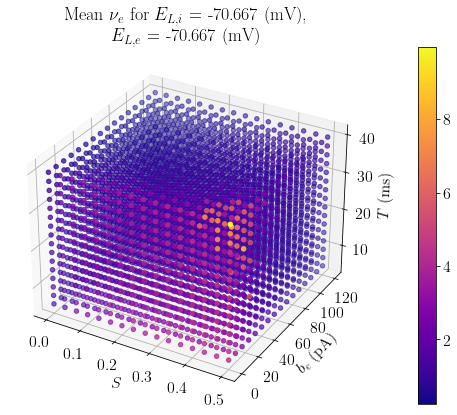

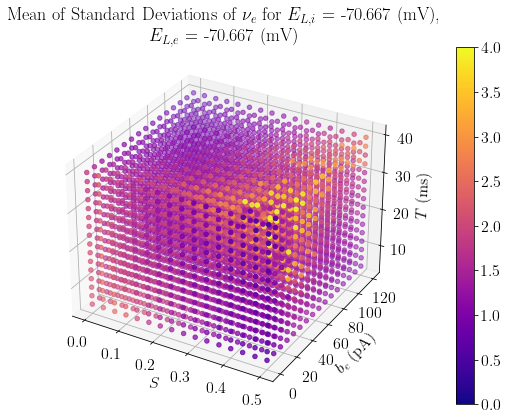

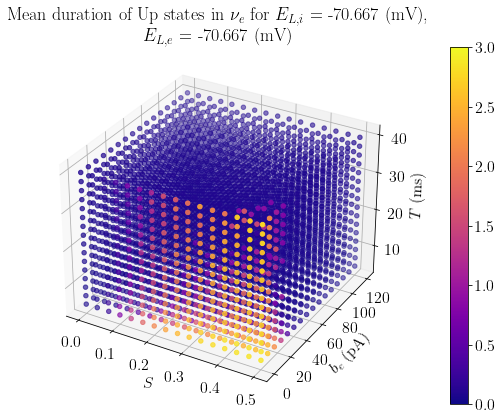

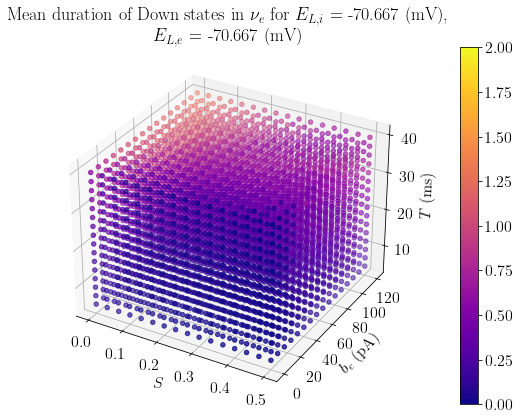

In [37]:
# Las voy a sacar asi y las juntaré, no me voy a comer más la cabeza
batches_folder = './JUSUFlike/Project/FinalResults/'
ELI = -70
ELE = -70
plot_metric_3d('mean_FR_e', ('a', 'b_e', 'T'), {'E_L_i': ELI, 'E_L_e': ELE}, batches_folder, 
                   steps=16, fig=None, ax=None, imshow_range=(None, None))
plt.show()
plot_metric_3d('means_of_std_e', ('a', 'b_e', 'T'), {'E_L_i': ELI, 'E_L_e': ELE}, batches_folder, 
                   steps=16, fig=None, ax=None, imshow_range=(0, 4))
plt.show()
plot_metric_3d('mean_up_e', ('a', 'b_e', 'T'), {'E_L_i': ELI, 'E_L_e': ELE}, batches_folder, 
                   steps=16, fig=None, ax=None, imshow_range=(0, 3))
plt.show()
plot_metric_3d('mean_down_e', ('a', 'b_e',  'T'), {'E_L_i': ELI, 'E_L_e': ELE}, batches_folder, 
                   steps=16, fig=None, ax=None, imshow_range=(0, 2))
plt.show()

# Guardarlas en .eps y hacer una figura junta con photoshop

# 3D plots of Parameter Space. Spectral Characteristics

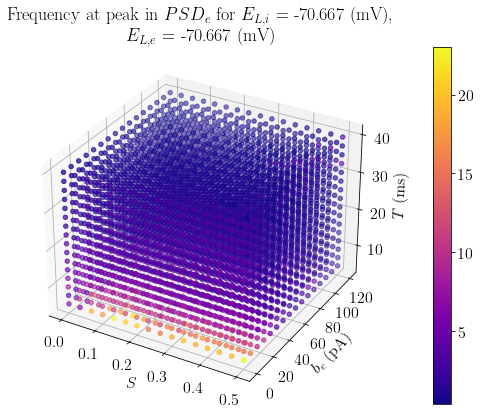

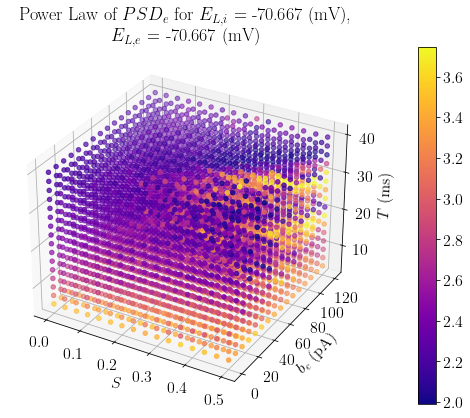

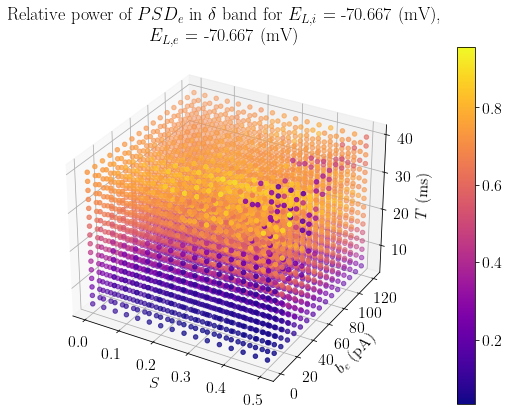

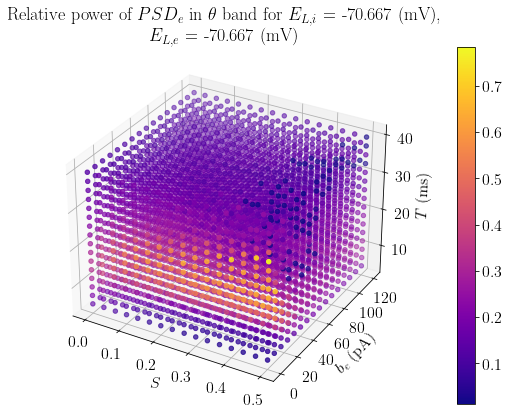

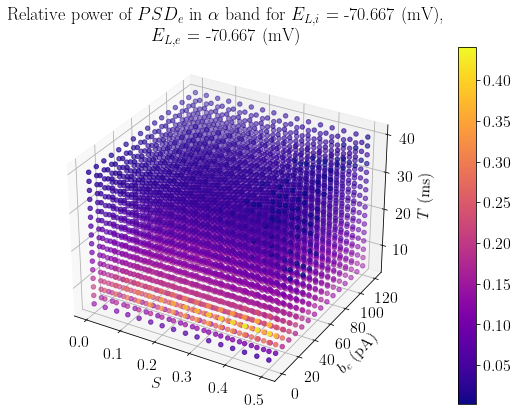

In [32]:
batches_folder = './JUSUFlike/Project/FinalResults/'
ELI = -70
ELE = -70
plot_metric_3d('fmax_prom_e', ('a', 'b_e', 'T'), {'E_L_i': ELI, 'E_L_e': ELE}, batches_folder, 
                   steps=16, fig=None, ax=None, imshow_range=(None, None))
plt.show()
plot_metric_3d('slope_PSD_e', ('a', 'b_e', 'T'), {'E_L_i': ELI, 'E_L_e': ELE}, batches_folder, 
                   steps=16, fig=None, ax=None, imshow_range=(None, None))
plt.show()
plot_metric_3d('delta_rel_p_e', ('a', 'b_e', 'T'), {'E_L_i': ELI, 'E_L_e': ELE}, batches_folder, 
                   steps=16, fig=None, ax=None, imshow_range=(None, None))
plt.show()
plot_metric_3d('theta_rel_p_e', ('a', 'b_e', 'T'), {'E_L_i': ELI, 'E_L_e': ELE}, batches_folder, 
                   steps=16, fig=None, ax=None, imshow_range=(None, None))
plt.show()
plot_metric_3d('alpha_rel_p_e', ('a', 'b_e', 'T'), {'E_L_i': ELI, 'E_L_e': ELE}, batches_folder, 
                   steps=16, fig=None, ax=None, imshow_range=(None, None))
plt.show()

# 3D Movie

In [ ]:
fixed_params = {'b_e':0}

# I have to think how to improve this movie function so that E_L_e can be swept
params_sweep_im = ('a', 'E_L_i', 'E_L_e')
param_sweep_time = 'T'

title_movie = 'pointsmaxJUSUF'
for key in fixed_params.keys():
    title_movie += '_' + key + str(fixed_params[key]) 
title_movie += 'frames' + param_sweep_time
print(title_movie)

movies_folder = '/home/master/Desktop/tests_hpc/figures/JUSUF/movie/'
batches_folder = './JUSUFlike/Project/FinalResults/'

steps = 16
metric = 'max_FR_e'
imshow_range = (0, 175)

make_movie_3d(metric, fixed_params, params_sweep_im, param_sweep_time, title_movie, movies_folder, 
                     batches_folder, steps, imshow_range=imshow_range, type_plot='points')

Image(filename=movies_folder + title_movie + '3d/' + title_movie + '.gif')

# Regions of interest (silence and high-probability of explosion) when changing E_L_e and E_L_i with changing asymmetric long-range coupling. This has to be adaptaed to the 16 values per parameter sweep

In [ ]:
plt.rcParams.update({'font.size': 14})
E_L_e_vals = np.linspace(-80, -60, 16)
E_L_i_vals = np.linspace(-80, -60, 16)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xticks(np.arange(0, 16, 3))
ax.set_xticklabels(np.arange(-60, -84, -4))
ax.set_yticks(np.arange(0, 16, 3))
ax.set_yticklabels(np.arange(-60, -84, -4))
ax.set_ylabel(r'$E_{L,e}$', fontsize=18)
ax.set_xlabel(r'$E_{L,i}$', fontsize=18)
a = np.ones((16, 16))
b = np.tril(a)
np.fill_diagonal(b, 0.5, 1)
for i in range(16):
    for j in range(16):
        E_L_e = E_L_e_vals[i]
        E_L_i = E_L_i_vals[j]
        if E_L_e > E_L_i - 4:
            b[i, j] = 1
        if E_L_e < E_L_i - 4:
            b[i, j] = 0.5
plt.imshow(b, cmap=plt.get_cmap('RdYlBu'), vmin=0, vmax=1)
plt.title(r"Effect of $E_{L,e}$ and  $E_{L,i}$. $a' = a$")
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 14})

a = np.ones((6, 6))
b = np.tril(a, 1)
for i in range(6):
    for j in range(6):
        if i + 1 == j:
            b[i, j] = 0.5
#np.fill_diagonal(b, 0.5, 1)



fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xticks(ticks=np.arange(6), labels=np.arange(-60, -84, -4))
ax.set_yticks(ticks=np.arange(6), labels=np.arange(-60, -84, -4))
ax.set_ylabel(r'$E_{L,e}$', fontsize=18)
ax.set_xlabel(r'$E_{L,i}$', fontsize=18)
plt.imshow(b, cmap=plt.get_cmap('RdYlBu'))
plt.title(r"Effect of $E_{L,e}$ and  $E_{L,i}$. $a' = 1.3a$")
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 14})

a = np.ones((6, 6))
b = np.tril(a, 1)
for i in range(6):
    for j in range(6):
        if i + 2 == j:
            b[i, j] = 0.5
#np.fill_diagonal(b, 0.5, 1)



fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xticks(ticks=np.arange(6), labels=np.arange(-60, -84, -4))
ax.set_yticks(ticks=np.arange(6), labels=np.arange(-60, -84, -4))
ax.set_ylabel(r'$E_{L,e}$', fontsize=18)
ax.set_xlabel(r'$E_{L,i}$', fontsize=18)
plt.imshow(b, cmap=plt.get_cmap('RdYlBu'))
plt.title(r"Effect of $E_{L,e}$ and  $E_{L,i}$. $a' = 1.6a$")
plt.show()

### Look for sets of parameters that result in the maximum value of a certain metric
It might happen that we want to find the sets of parameters that result in obtaining the highest values of metrics. For instance, let's see which sets of parameters get us the higher number of DMN regions in the top 10 regions with highest mean FR. 

In [ ]:
# 'ratio_frmean_dmn_exc': 41, 'ratio_zscore_dmn_exc': 42
max_value_metric, pars_where_max, idxes = params_of_max_metric("ratio_zscore_dmn_exc",
                                                        batches_folder, avoid_bp = True, steps=16, verbose=True)

### Do all combinations of sweeps to check the parameter sweep went well

In [ ]:
import itertools
execute = False
fixed_params = {'a': 0.3, 'E_L_e': -80, 'E_L_i': -80}
params_sweep = ('b_e', 'T')

parameters = ['a', 'b_e', 'E_L_i', 'E_L_e', 'T']

if execute:
    for params_sweep in itertools.combinations(parameters, 2):
        fixed_list = parameters.copy()
        for param in params_sweep:
            fixed_list.remove(param)
        fixed_params = {}
        for fixed in fixed_list:
            if fixed == 'a':
                fixed_params[fixed] = 0.5*np.random.rand()
            elif fixed == 'b_e':
                fixed_params[fixed] = 120 * np.random.rand()
            elif fixed == 'E_L_i':
                fixed_params[fixed] = -60 - 20 * np.random.rand()
            elif fixed == 'E_L_e':
                fixed_params[fixed] = -60 - 20 * np.random.rand()
            elif fixed == 'T':
                fixed_params[fixed] = 40*np.random.rand()
        print(params_sweep)
        print(fixed_params)
        steps = 6
        metrics = ['mean_FR_e', 'mean_FR_i', 'max_FR_e', 'mean_FC_e', 
                   'ratio_zscore_dmn_inh', 'ratio_frmean_dmn_exc']
        fig = plot_multiple_metrics(metrics, batches_folder, params_sweep, fixed_params, steps)
        plt.show()

## Count how many combinations of parameters result in the broken point

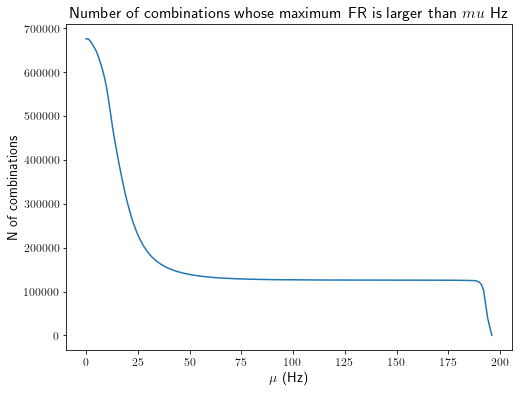

In [4]:
coeff_sweep = 'coeff_inh_1'

figures_folder = '/home/master/Desktop/tests_hpc/figures/sweep_step6/' + coeff_sweep + '/'
batches_folder = './JUSUFlike/Project/FinalResults/'

max_FRs_e = load_metric_sweeps('max_FR_e', batches_folder, steps=16)
max_FRs_i = load_metric_sweeps('max_FR_i', batches_folder, steps=16)

broken_point = np.amax(max_FRs_e)
max_frs = np.arange(np.ceil(broken_point) + 1)
n_combs_over = np.zeros_like(max_frs)
n_combs_over_e = np.zeros_like(max_frs)

for ii, max_fr in enumerate(max_frs):
    n_combs_over[ii] = np.sum(np.logical_and(max_FRs_e[:, -1] > max_fr, max_FRs_i[:, -1] > max_fr))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(max_frs, n_combs_over)
ax.set(xlabel='$\mu$ (Hz)', ylabel='N of combinations', 
       title='Number of combinations whose maximum FR is larger than $mu$ Hz')
#fig.savefig(figures_folder + 'curve_bps.png')
plt.show()

In [6]:
# Let us count the parameters that have the highest values
n_params = 5
steps_per_par = 16
label_params = ['a', 'b_e (pA)', 'E_L_i (mV)', 'E_L_e (mV)', 'T (ms)']
range_pars = [(0, 0.5), (0, 120.0), (-80.0, -60.0), (-80.0, -60.0), (5.0, 40.0)]
all_bins = []
all_counts = []
all_centers = []
for id_param in range(n_params):
    bins = np.zeros(steps_per_par + 1)  # 6 steps per parameter
    vals = np.round(np.linspace(range_pars[id_param][0], range_pars[id_param][1], steps_per_par), 3)
    step = vals[1] - vals[0]
    bins = np.linspace(vals[0], vals[-1] + step, steps_per_par + 1) - step / 2
    centers = np.linspace(vals[0], vals[-1], steps_per_par)
    all_bins.append(bins)
    all_counts.append(np.zeros(steps_per_par))
    all_centers.append(centers)

for idx, (param_centers, param_counts) in enumerate(zip(all_centers, all_counts)):
    for ii, value in enumerate(param_centers):
        param_counts[ii] = np.sum(np.logical_and(max_FRs_e[:, -1] > broken_point-2, 
                                                 max_FRs_e[:, idx] == value))


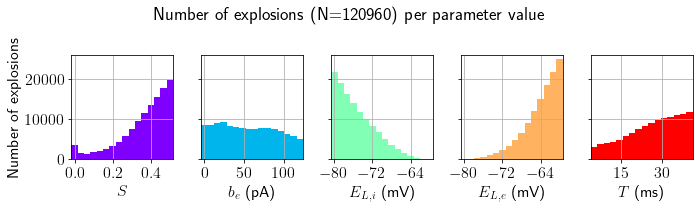

In [23]:
from matplotlib.ticker import MaxNLocator
fig, axes = plt.subplots(1, n_params, figsize=(10, 3), sharey=True)
color = iter(plt.cm.rainbow(np.linspace(0, 1, n_params)))

limit_val = 190
idxes = max_FRs_e[:, -1] > limit_val
number_of_bp = np.sum(idxes)
for ii, ax in enumerate(axes):
    c = next(color)
    ax.hist(max_FRs_e[idxes, ii], bins=all_bins[ii], align='mid', color=c)
    
    ax.set(ylim=(0, 26000), xlabel=fig_labels[ii],xlim=(all_bins[ii][0], all_bins[ii][-1]))
    # ticks
    ax.xaxis.set_major_locator(MaxNLocator(3)) 
    if ii == 0:
        ax.set(ylabel='Number of explosions')
    ax.grid()
fig.suptitle(f'Number of explosions (N={number_of_bp}) per parameter value')
plt.tight_layout()
fig.savefig('./figures/figures_report/' + 'distribution_bps_1d.eps')
plt.show()

/tmp/ipykernel_15936/2154856783.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


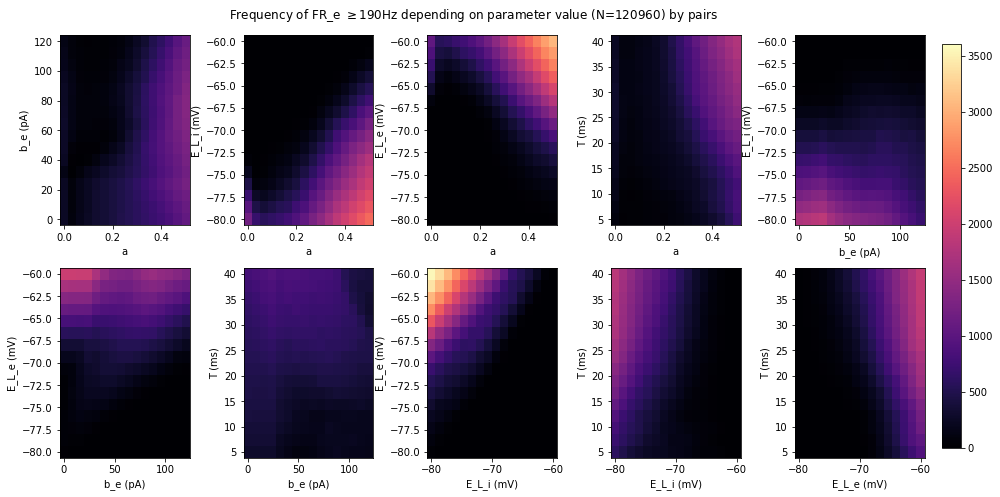

In [8]:
from itertools import combinations
fig, axes = plt.subplots(2, 5, figsize=(13, 7))
axes = axes.flatten()
limit_val = 190
idxes = max_FRs_e[:, -1] > limit_val
number_of_bp = np.sum(idxes)
for ii, (parx, pary) in enumerate(combinations(label_params, 2)):
    idx_parx = label_params.index(parx)
    idx_pary = label_params.index(pary)
    h = axes[ii].hist2d(max_FRs_e[idxes, idx_parx], max_FRs_e[idxes, idx_pary], 
                  bins=[all_bins[idx_parx], all_bins[idx_pary]], vmin=0, vmax=3600, cmap=plt.magma())
    # print(np.amax(np.array(h[0])))  # To determine max of 
    axes[ii].set(xlabel=label_params[idx_parx], ylabel=label_params[idx_pary])


cb_ax = fig.add_axes([1,.105,.02,.8])
fig.suptitle(f'Frequency of FR_e $\geq${limit_val}Hz depending on parameter value (N={number_of_bp}) by pairs')
fig.colorbar(h[-1],orientation='vertical',cax=cb_ax)
plt.tight_layout()

#fig.savefig(figures_folder + 'distribution_bps_2D.png')
plt.show()

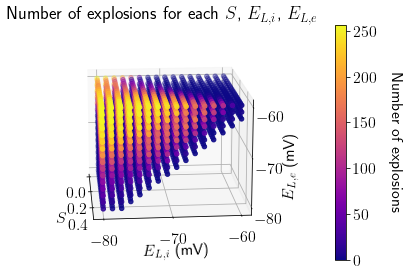

In [22]:
import itertools
def plot_3d_p_explosion(results_folder, steps=16, fig=None, ax=None, imshow_range=None, type_plot='points'):
    """I want it to show the probability of explosion for the 3d plot."""
    params = ('a', 'E_L_i', 'E_L_e')
    list_values = []
    xvals = np.round(np.linspace(ranges_params[params[0]][0], ranges_params[params[0]][1], steps), 3)
    yvals = np.round(np.linspace(ranges_params[params[1]][0], ranges_params[params[1]][1], steps), 3)
    zvals = np.round(np.linspace(ranges_params[params[2]][0], ranges_params[params[2]][1], steps), 3) 
    
    idx_i = params.index('E_L_i')
    idx_e = params.index('E_L_e')

    name_metric = 'max_FR_e'
    d_data = load_metric_sweeps(name_metric, results_folder, steps=steps)
    
    clean_data = np.empty((2640, 4))
    ii = 0
    for comb in itertools.product(xvals, yvals, zvals):
        if (comb[idx_e] + 4) > comb[idx_i]:
            clean_data[ii, :-1] = comb
            # Now I have to find the idxes in dirty data, it's size should be around 256
            idxes = np.logical_and.reduce((d_data[:, dict_params[params[0]]] == comb[0], 
                                           d_data[:, dict_params[params[1]]] == comb[1],
                                           d_data[:, dict_params[params[2]]] == comb[2]))
            
            # Now we sum explosions
            clean_data[ii, -1] = np.sum(d_data[idxes, -1] > 175.0)
            
            # I could also do a fraction or ratio or probability of explosion by dividing it by 256.
            ii += 1
            
        else:
            continue

    x_arr = clean_data[:, 0]
    y_arr = clean_data[:, 1]
    z_arr = clean_data[:, 2]
    c_arr = clean_data[:, -1]

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111, projection='3d')
    # Make a nice title
    title = 'Number of explosions for each $S$, $E_{L,i}$, $E_{L,e}$'
    if type(imshow_range) is type(None):
        imshow_range = (None, None)
    # plot the image and manage the axis
    
    img = ax.scatter(x_arr, y_arr, z_arr, c=c_arr, cmap=plt.plasma(), vmin=imshow_range[0], vmax=imshow_range[1])
    
    # Improve title and it should be ok!
    ax.set(xlabel=fig_labels[dict_params[params[0]]], ylabel=fig_labels[dict_params[params[1]]], 
           zlabel=fig_labels[dict_params[params[2]]], title=title)

    plt.tight_layout()
    cbar = fig.colorbar(img, pad=0.1)
    cbar.ax.set_ylabel('Number of explosions', rotation=270, labelpad=26)
    for ii in range(0, 360, 5):
        ax.view_init(elev=15.0, azim=ii)
        fig.savefig("./figures/explosions/movie%d.png" % ii)
        if ii == 305:
            fig.savefig('./figures/figures_report/explosions_3d.eps')
    
    images = []
    movie_folder = './figures/explosions/'
    title_movie = 'explosions'
    for step in range(0, 360, 5):
        filename = movie_folder + f'movie{step}.png'
        images.append(imageio.imread(filename))
    imageio.mimsave(movie_folder + title_movie + '.gif', images, duration=0.15)
    
    return fig, ax

batches_folder = './JUSUFlike/Project/FinalResults/'
fig, ax = plot_3d_p_explosion(batches_folder, steps=16, fig=None, ax=None, imshow_range=None, type_plot='points')


## Plot the time traces of the interesting regions of the parameter space.

The plots that might be interesting to have:
A plot of 6x(2 or 3) where we sweep the different values of bs in the rows and the values of a in the columns (a = 0.3, 0.4, 0.5 max) and see how they change.

It will also be interesting to have individual plots of the corners of the parameter space. So the extreme cases of a = 0, 0.5 and b = 0, 120. Additionally some in the middle for the FC.

This can be iteratively done for changing T, that way we can see how the landscape changes. I don't know how all this could be plotted in a nice figure tho (meaning the parameter grid and the regions)

In [ ]:
coeff_inh = 1.1
E_L_i = -68
E_L_e = -60
Ts = [26]  # Do it for every T that we have computed
all_bs = np.flip(np.linspace(0, 120, 6)).tolist() # Interesting cases plot everything.
as_all_bs = [0.3, 0.4]


ELS = f'ELI_{E_L_i}_ELE_{E_L_e}'
folder_figures = f'/home/master/Desktop/tests_hpc/figures/sweep_step6/coeff_inh_{coeff_inh}/timetraces/' + ELS + '/'

try:
    os.listdir(folder_figures)
except:
    os.mkdir(folder_figures)

folder_root = f'/media/master/Nuevo vol/Internship/Data/hpc_tvbadex/results_for_plotting/coeff_inh{coeff_inh}/' + ELS + '/'
run_sim = 5000.0
cut_transient = 2000.0

for T in Ts:
    # Then the sweeps
    fig, axes = plt.subplots(len(all_bs), len(as_all_bs),
                        figsize=(6 * len(as_all_bs), 4 * len(all_bs)),
                        sharex='col', sharey='row')
    
    rand_nodes = np.random.default_rng().choice(68, size=3, replace=False)
    fig2, axes2 = plt.subplots(len(all_bs), len(as_all_bs),
                        figsize=(6 * len(as_all_bs), 4 * len(all_bs)),
                        sharex='col', sharey='row')
    for jj, a in enumerate(as_all_bs):
        for ii, b in enumerate(all_bs):
            if len(as_all_bs) == 1:
                ax = axes[ii]
                ax2 = axes2[ii]
            else:
                ax = axes[ii, jj]
                ax2 = axes2[ii, jj]

            # Load results
            label_sim = '_a_' + str(a) + '_b_' + str(b) + f'_ELI_{E_L_i}_ELE_{E_L_e}_T_' + str(T) + '/'
            file_name = folder_root + label_sim
            result = tools.get_result(file_name, cut_transient, run_sim)
            FR_exc = result[0][1][:, 0, :] * 1e3
            FR_inh = result[0][1][:, 1, :] * 1e3
            time_s = result[0][0] * 1e-3
            del result
            
            # Plot all regions
            Li = ax.plot(time_s, FR_inh, label='Inh', c='darkred')
            Le = ax.plot(time_s, FR_exc, label='Exc', c='SteelBlue')
            ax.set(xlim=(3, 5), ylim=(-5, 60))
            if ii == 0:
                if len(as_all_bs) == 1:
                    ax.set_title(f'a = {a}, b = {b}pA')
                else:
                    ax.set_title(f'a={a}')
            else:
                if len(as_all_bs) == 1:
                    ax.set_title(f'b = {b}pA')
            if ii == len(all_bs) - 1:
                ax.set(xlabel='Time (s)')
            if jj == 0:
                ax.set(ylabel='Firing rate (Hz)')
            ax.grid()
            
            # Plot some regions
            Li = ax2.plot(time_s, FR_inh[:, rand_nodes], label='Inh', c='darkred')
            Le = ax2.plot(time_s, FR_exc[:, rand_nodes], label='Exc', c='SteelBlue')
            ax2.set(xlim=(3, 5), ylim=(-5, 60))
            if ii == 0:
                if len(as_all_bs) == 1:
                    ax.set_title(f'a = {a}, b = {b}pA')
                else:
                    ax.set_title(f'a={a}')
            else:
                if len(as_all_bs) == 1:
                    ax.set_title(f'a = {a}, b = {b}pA')
            if ii == len(all_bs) - 1:
                ax2.set(xlabel='Time (s)')
            if jj == 0:
                ax2.set(ylabel='Firing rate (Hz)')
            ax2.grid()

    height = 1/(len(all_bs))
    for yy in range(len(all_bs)):
        if len(as_all_bs) != 1:
            xtext = 0.015
            plt.text(xtext, height, f'b={int(all_bs[-(yy+1)])}', transform=plt.gcf().transFigure)
            height += 0.1325
    fig2.savefig(folder_figures + f'sweeps_ELI_{E_L_i}_ELE_{E_L_e}_T_' + str(T) + '_a_' + str(a) + '_fewnodes.png')
    plt.close(fig2)
    height = 1/(len(all_bs))
    for yy in range(len(all_bs)):
        if len(as_all_bs) != 1:
            xtext = 0.015
            plt.text(xtext, height, f'b={int(all_bs[-(yy+1)])}', transform=plt.gcf().transFigure)
            height += 0.1325
    fig.savefig(folder_figures + f'sweeps_ELI_{E_L_i}_ELE_{E_L_e}_T_' + str(T) + '_a_' + str(a) + '.png')
    plt.show()

# Looking for values that might result in longer upstates
In what metrics might we be interested:
- As always, the max FR since it will let us know when we reach the broken point
- Mean and standard deviation of the firing rate. It should be useful to let us know if we are in UD state or not.
- I am guessing mean up and mean down duration although the algorithm might not be as optimal as needed.
- fmax and pmax might also be useful although I don't trust them completely.
- delta alpha beta relative power

And what parameters will we want to observe?
- I think we can fix b. Justifying that we already have UD states when varying b. Now we want to see what other combinations of parameters allow us to obtain longer UD states.
- From preliminary results it seemed that low connectivity + higher b might help us obtain those sustained up states. So we might try to fix a low and b high and see the results.
- As a first approach, maybe just leave one E_L fixed in the classical ~64 mV value and sweep over T and other E_L_s. The problem will eb

In [ ]:
batches_folder = './batches_sweep6/'
fixed_params = {'T': 20, 'E_L_i': -64, 'E_L_e': -64}
params_sweep = ('b_e', 'a')

steps = 6
metrics = ['fmax_amp_e', 'mean_FR_e', 'mean_FC_e',
           'pmax_amp_e', 'mean_FR_i', 'max_FR_e',
           'delta_rel_p_e', 'theta_rel_p_e', 'alpha_rel_p_e',
           'beta_rel_p_e', 'mean_up_e', 'mean_down_e']
fig = plot_multiple_metrics(metrics, batches_folder, params_sweep, fixed_params, steps)
plt.show() 

# Plotting SCFC correlation with FC values in the model

In [51]:
batches_folder = './JUSUFlike/Project/FinalResults/'
scfc = load_metric_sweeps('corr_FC_SC_e', batches_folder, steps=16)
fc = load_metric_sweeps('mean_FC_e', batches_folder, steps=16)
max_FRs = load_metric_sweeps('max_FR_e', batches_folder, steps=16)
no_bps_idxes = max_FRs[:, -1] < 180
no_a_0s = max_FRs[:, 0] > 0.2

[]

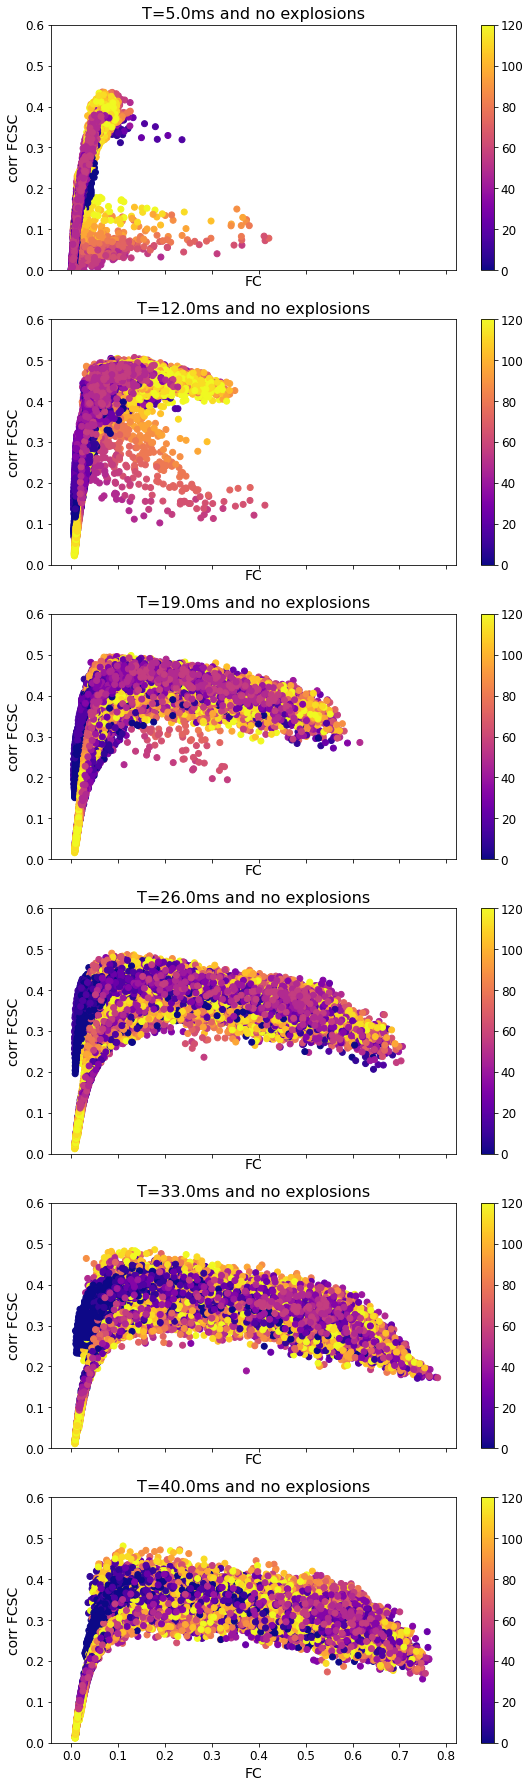

In [52]:
# Fix parameters
fig, axes = plt.subplots(6, 1, figsize=(8, 25), sharex='col')
ii = 0
for T in np.linspace(5, 40, 16)[::3]:
    fixed_params = {'T': T}
    idxs_scfc = []
    idxs_fc = []
    for param in fixed_params:
        closest_val = find_closest_val(param, fixed_params[param], 16)
        idxs_scfc.append(scfc[:, dict_params[param]] == closest_val)
        idxs_fc.append(fc[:, dict_params[param]] == closest_val)
    
    scfc_clean = scfc[np.logical_and.reduce(idxs_scfc + [np.invert(np.all(scfc == 0, axis = 1)),
                                                         no_bps_idxes, no_a_0s]), :]
    fc_clean = fc[np.logical_and.reduce(idxs_fc + [np.invert(np.all(fc == 0, axis = 1)),
                                                  no_bps_idxes, no_a_0s]), -1]
    im = axes[ii].scatter(fc_clean, scfc_clean[:, -1], c=scfc_clean[:, 1])  # Color coded by b
    axes[ii].set(ylim=(0, 0.6), ylabel='corr FCSC', xlabel='FC', title=f'T={round(T, 2)}ms and no explosions')
    fig.colorbar(im, ax=axes[ii])
    ii += 1

plt.tight_layout()
plt.plot()

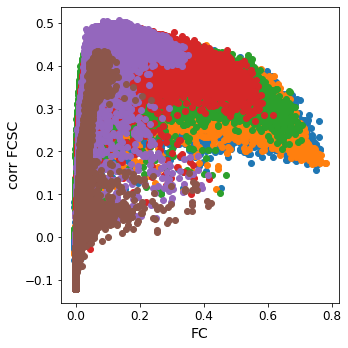

In [53]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(5, 5))
axes = fig.add_subplot()
for T in np.linspace(40, 5, 16)[::3]:
    fixed_params = {'T': T}
    idxs_scfc = []
    idxs_fc = []
    for param in fixed_params:
        closest_val = find_closest_val(param, fixed_params[param], 16)
        idxs_scfc.append(scfc[:, dict_params[param]] == closest_val)
        idxs_fc.append(fc[:, dict_params[param]] == closest_val)
    
    scfc_clean = scfc[np.logical_and.reduce(idxs_scfc + [np.invert(np.all(scfc == 0, axis = 1)),
                                                         no_bps_idxes]), -2:]
    fc_clean = fc[np.logical_and.reduce(idxs_fc + [np.invert(np.all(fc == 0, axis = 1)),
                                                  no_bps_idxes]), -1]
    
    scfc_clean = scfc[np.logical_and.reduce(idxs_scfc + [np.invert(np.all(scfc == 0, axis = 1)),
                                                         no_bps_idxes]), -1:]
    fc_clean = fc[np.logical_and.reduce(idxs_fc + [np.invert(np.all(fc == 0, axis = 1)),
                                                  no_bps_idxes]), -1]
    
    axes.scatter(fc_clean, scfc_clean)
    axes.set(ylabel='corr FCSC', xlabel='FC')
plt.tight_layout()
plt.show()

TypeError: Axes3D.plot() missing 2 required positional arguments: 'xs' and 'ys'

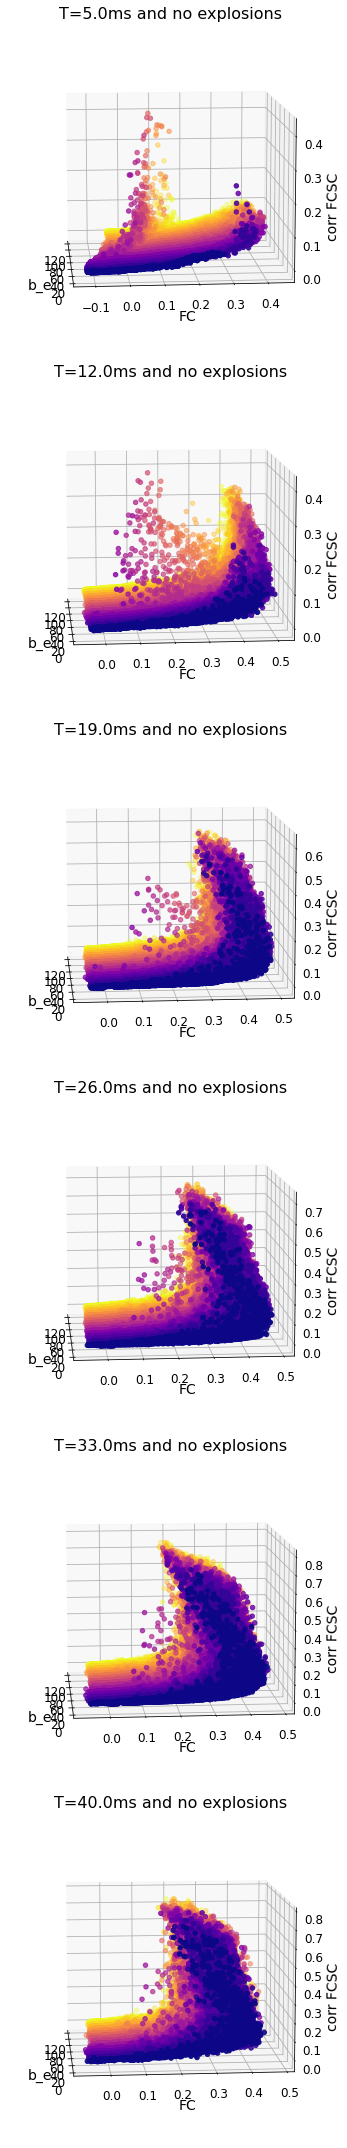

In [54]:
# Fix parameters
fig, axes = plt.subplots(6, 1, figsize=(12, 30), subplot_kw=dict(projection='3d'))
ii = 0

for T in np.linspace(5, 40, 16)[::3]:
    fixed_params = {'T': T}
    idxs_scfc = []
    idxs_fc = []
    for param in fixed_params:
        closest_val = find_closest_val(param, fixed_params[param], 16)
        idxs_scfc.append(scfc[:, dict_params[param]] == closest_val)
        idxs_fc.append(fc[:, dict_params[param]] == closest_val)
    
    scfc_clean = scfc[np.logical_and.reduce(idxs_scfc + [np.invert(np.all(scfc == 0, axis = 1)),
                                                         no_bps_idxes]), :]
    fc_clean = fc[np.logical_and.reduce(idxs_fc + [np.invert(np.all(fc == 0, axis = 1)),
                                                  no_bps_idxes]), -1]
    axes[ii].scatter(scfc_clean[:, 1], scfc_clean[:, -1], fc_clean, c=scfc_clean[:, 1])
    axes[ii].set(zlabel='corr FCSC', ylabel='FC', title=f'T={round(T, 2)}ms and no explosions', 
                 xlabel='b_e')
    axes[ii].invert_xaxis()
    ii += 1


for ii in range(0, 360, 5):
    for ax in axes:
        ax.view_init(elev=10., azim=ii)
    plt.savefig("./fig_tests/movie%d.png" % ii)
plt.tight_layout()
plt.plot()

In [ ]:
import imageio
images = []
for step in range(0, 360, 5):
    filename = f'./fig_tests/movie{step}.png'
    images.append(imageio.imread(filename))
imageio.mimsave('./fig_tests/gif_FC_SC.gif', images, duration=0.15)

In [58]:
for a in range(30, 80, 10):
    print(a)

30
40
50
60
70


# Another attempt at prediction inspired by the previous one

In [33]:
from numba import njit
@njit(fastmath=True)
def traces_process(metric_arr, max_FRs, comb_array, skip_null_a=True):
    """Function to process the data in a way that the metric of a network can be plotted as traces changing with b"""

    # I want to put in a single matrix the 16 values of corrFCSC ordered by increasing b_e and then the 4 params

    nrows = int(675840 / 16)  # Since the b combinations won't be considered, will be "flattened in that dimension"

    data = np.empty((nrows, 20))  # 16 first columns for corrFCSC values and other 4 for parameters

    # I will sweep over each row in the 675840 combinations. It might be interesting to transform it in a numba fun.

    # Quite slow!
    cont_row = 0
    for ii in range(comb_array.shape[0]):
        param_vals = comb_array[ii]
        if skip_null_a and param_vals[0] == 0:
            continue
        else:    
            a_idxs = metric_arr[:, 0] == param_vals[0]
            ELI_idxs = metric_arr[:, 2] == param_vals[1]
            ELE_idxs = metric_arr[:, 3] == param_vals[2]
            T_idxs = metric_arr[:, 4] == param_vals[3]
            # Ugly but needed for numba
            idxes = np.logical_and(a_idxs, ELI_idxs)
            idxes = np.logical_and(idxes, ELE_idxs)
            idxes = np.logical_and(idxes, T_idxs)

            # Check if explosions in the 16 values
            max_temp = max_FRs[idxes, -1]
            if max_temp.size == 16:  # If not 16 means that the combination does not exist
                if np.amax(max_temp) > 175: # If there is an explosion, ignore
                    continue
                else:
                    metric_temp = metric_arr[:, np.array([1, 5])][idxes]  # We take b and corr columns and then select those we want
                    metrics = metric_temp[metric_temp[:, 0].argsort()][:, 1]  # Sort wrt to b and take col of corr to add to data
                    data[cont_row, :16] = metrics
                    data[cont_row, 16:] = param_vals

                    cont_row += 1
    data = data[:cont_row, :]  # Get rid of the empty rows
    
    return data

In [34]:
batches_folder = './JUSUFlike/Project/FinalResults/'
scfc = load_metric_sweeps('corr_FC_SC_e', batches_folder, steps=16)
fc = load_metric_sweeps('mean_FC_e', batches_folder, steps=16)
max_FRs = load_metric_sweeps('max_FR_e', batches_folder, steps=16)

avals = np.round(np.linspace(ranges_params['a'][0], ranges_params['a'][1], 16), 3)
bvals = np.round(np.linspace(ranges_params['b_e'][0], ranges_params['b_e'][1], 16), 3)
ELIvals = np.round(np.linspace(ranges_params['E_L_i'][0], ranges_params['E_L_i'][1], 16), 3)
ELEvals = np.round(np.linspace(ranges_params['E_L_e'][0], ranges_params['E_L_e'][1], 16), 3)
Tvals = np.round(np.linspace(ranges_params['T'][0], ranges_params['T'][1], 16), 3)

comb_array = np.empty((16**4, 4))
for ii, comb in enumerate(itertools.product(avals, ELIvals, ELEvals, Tvals)):
    comb_array[ii, :] = comb

In [35]:
#%timeit
data = traces_process(scfc, max_FRs, comb_array, skip_null_a=True)  # Takes long even with numba...
np.save('./data/corrFCSCprocessed.npy', data)

In [36]:
# Might be interesting to save this
data = np.load('./data/corrFCSCprocessed.npy')
print(data.shape)

(25890, 20)


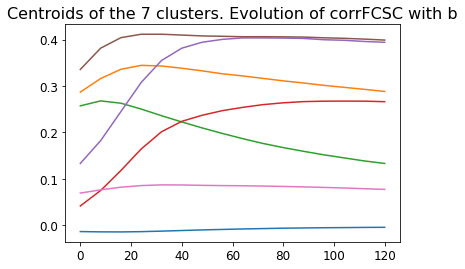

21


[]

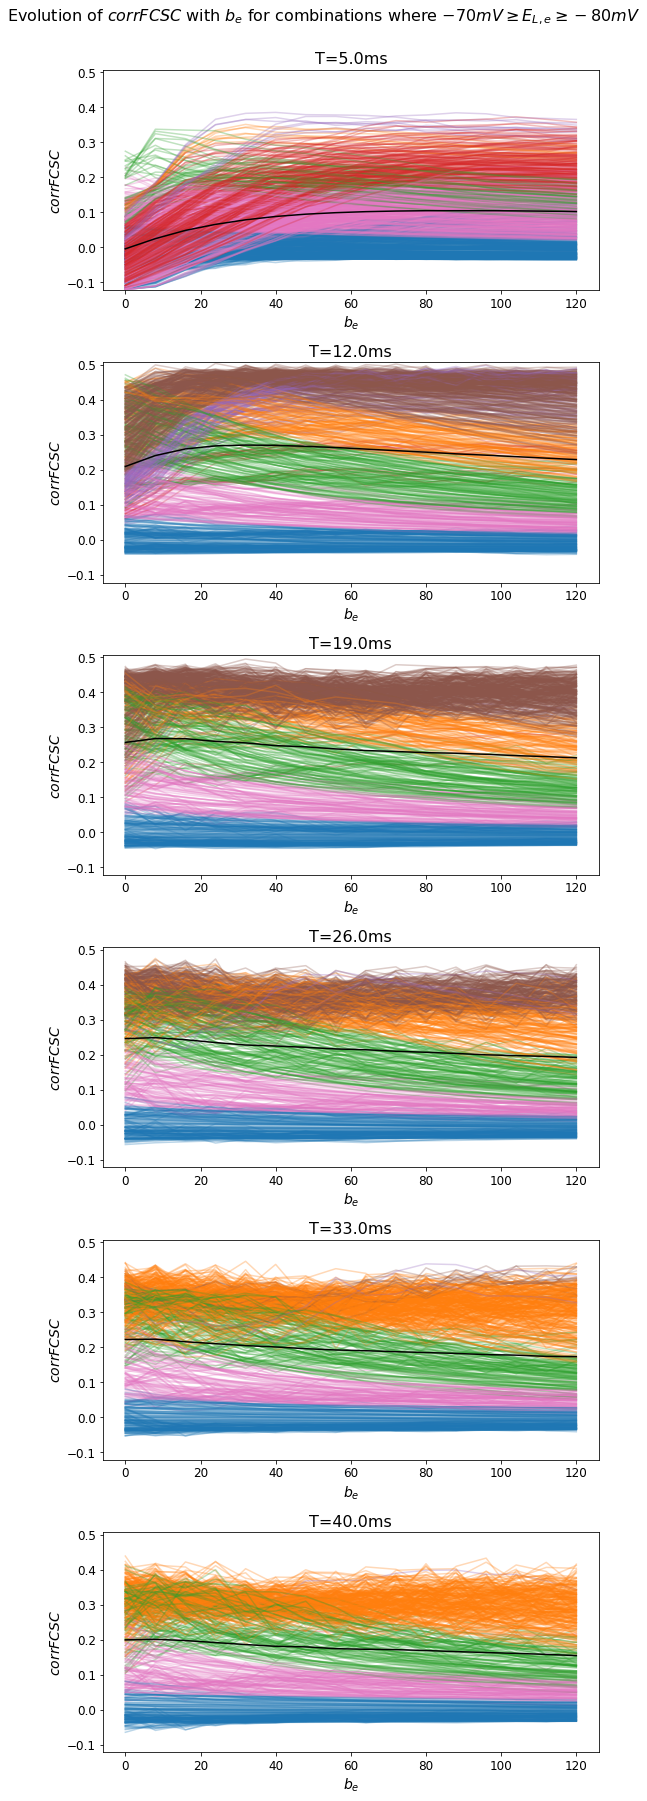

In [77]:
# Just one, I will now do both of them and also histograms of couples.
n_clusters = 7
metric = 'corrFCSC'
ELEmaxmin = (-70, -80)

if metric == 'FC':
    data = np.load('./data/FCprocessed.npy')
elif metric == 'corrFCSC':
    data = np.load('./data/corrFCSCprocessed.npy')
else:
    raise ValueError('Select a correct value of metric (FC or corrFCSC)')

kmeans = KMeans(n_clusters=n_clusters).fit(data[:, :16])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(np.linspace(0, 120, 16), kmeans.cluster_centers_.T)
ax.set(title=f'Centroids of the {n_clusters} clusters. Evolution of {metric} with b')
plt.show()
print(kmeans.n_iter_)


palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink',
           'tab:grey', 'tab:olive', 'tab:cyan']

palette = palette[:n_clusters]
fig, axes = plt.subplots(6, 1, figsize=(8, 25))
ii = 0
ylim = (np.amin(data[:, :16]), np.amax(data[:, :16]))
for T in np.linspace(5, 40, 16)[::3]:
    # So what we want is a fixed value of T, and E_L_e > 70 (which will automatically constrict E_L_i)
    T_idxs = data[:, -1] == T
    ELE_idxs = np.logical_and(data[:, -2] <= ELEmaxmin[0], data[:, -2] >= ELEmaxmin[1])
    data_plot = data[np.logical_and(T_idxs, ELE_idxs), :17]  # Let's keep also a to color code
    labels = kmeans.labels_[np.logical_and(T_idxs, ELE_idxs)]
    colors = [palette[idx] for idx in labels]
    # I want now to plot the lines taking a as colormap, it would be cool
    mean = np.mean(data_plot[:, :16], axis=0)
    for kk, row in enumerate(data_plot):
        axes[ii].plot(np.linspace(0, 120, 16), row[:16], c=colors[kk], alpha=0.3)
    #axes[ii].plot(np.linspace(0, 120, 16), data_plot[:, :16].T, c=colors, alpha=0.1)  # Color coded by b
    axes[ii].plot(np.linspace(0, 120, 16), mean, c='k', alpha=1)

    axes[ii].set(ylim=ylim, ylabel=f'${metric}$', xlabel='$b_e$', 
                 title=f'T={round(T, 2)}ms')
    #fig.colorbar(im, ax=axes[ii])
    ii += 1
    
suptitle = 'Evolution of $' + metric + '$ with $b_e$ for combinations where $' + str(ELEmaxmin[0]) + \
'mV \geq E_{L,e} \geq' + str(ELEmaxmin[1]) + 'mV$'
fig.suptitle(suptitle, y=1)
plt.tight_layout()
plt.plot()

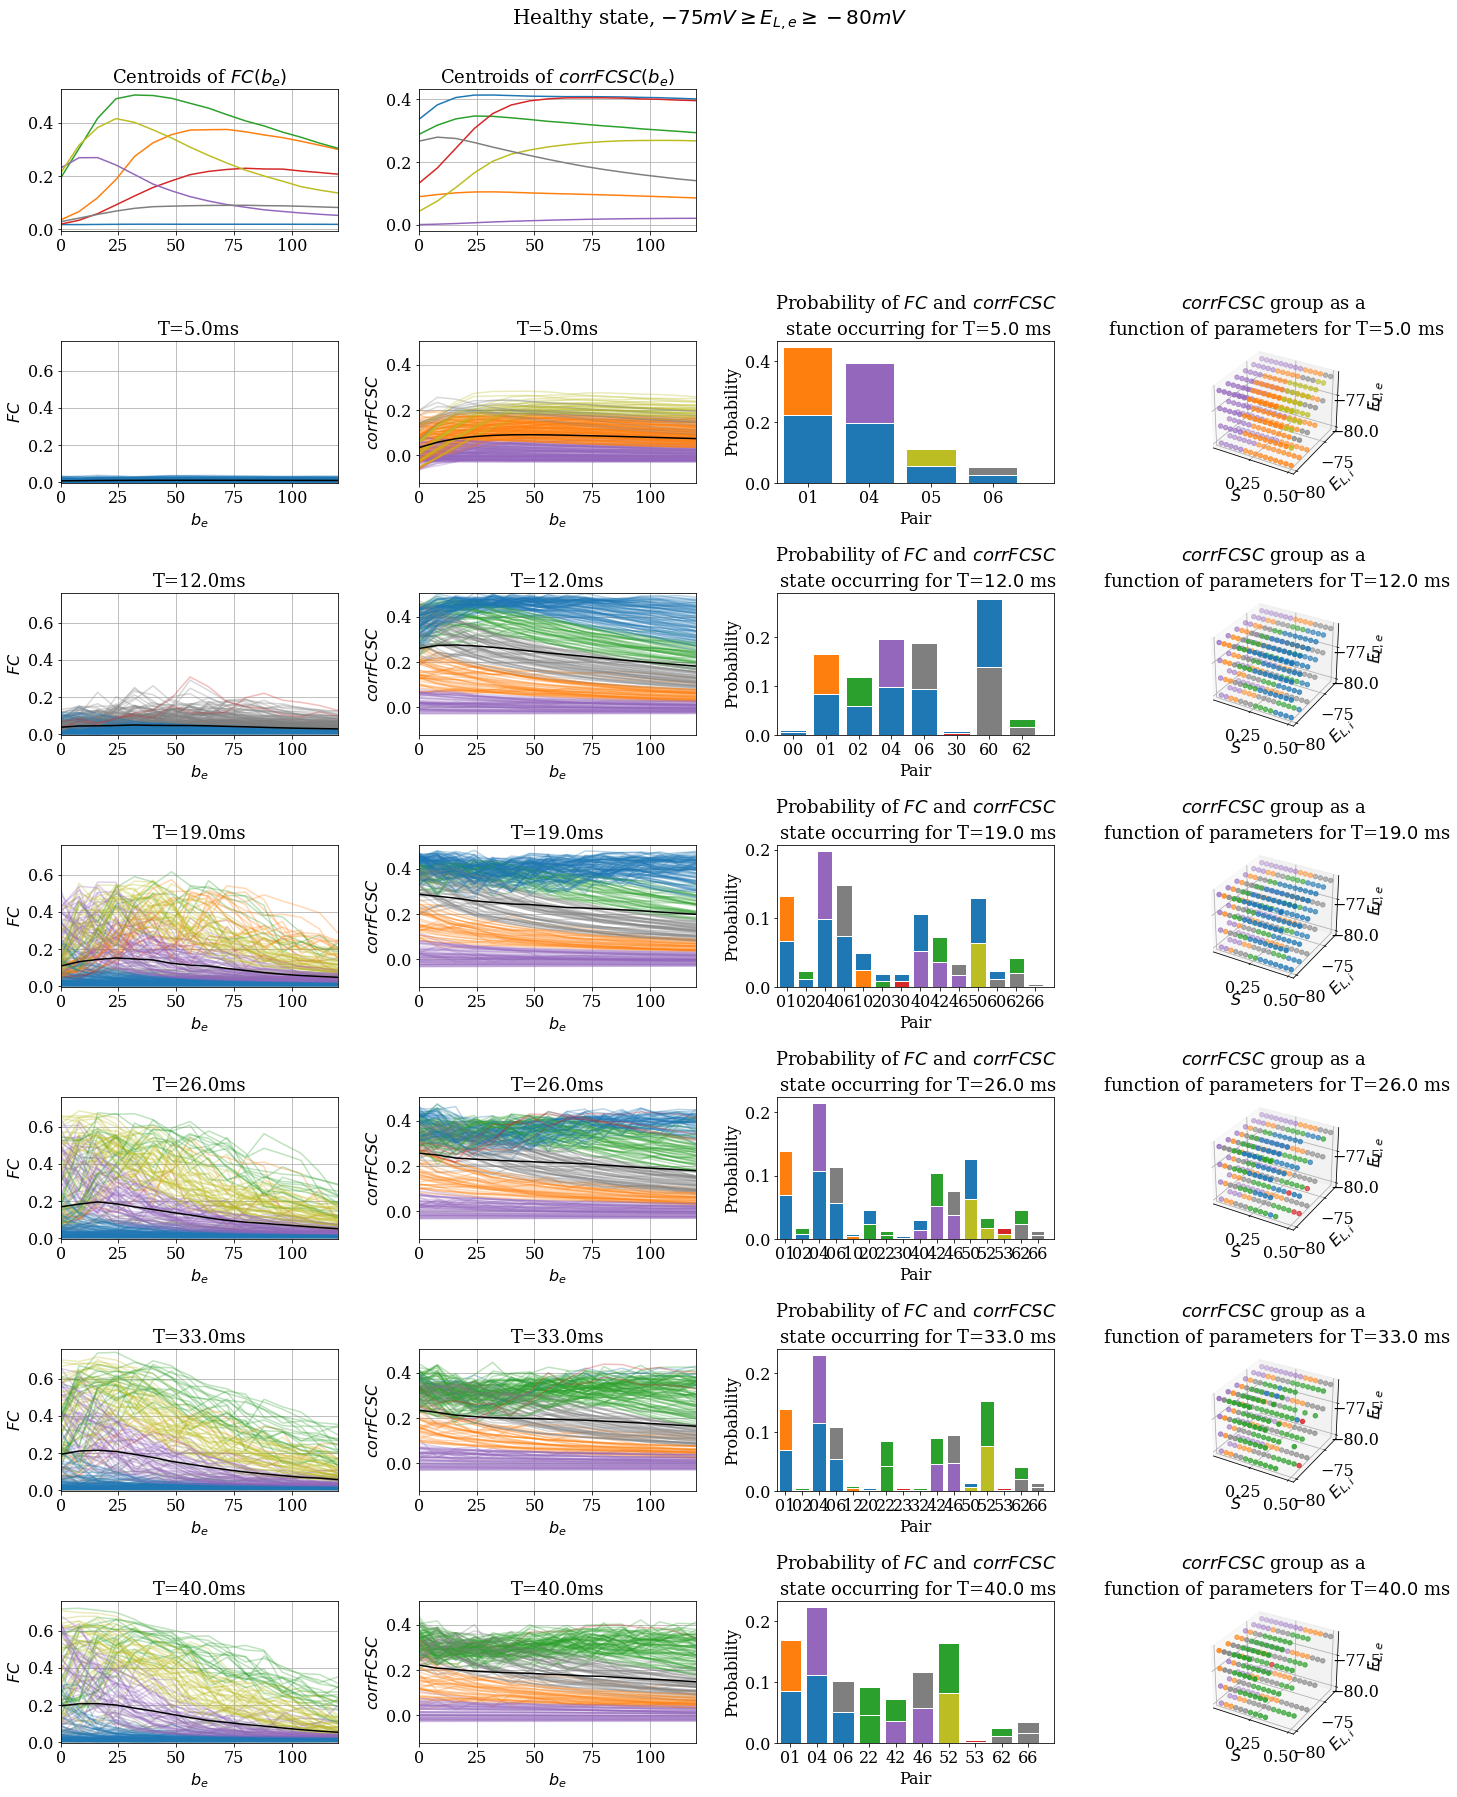

In [54]:
n_clusters = 7
ELEmaxmin = (-75, -80)
state = 'Healthy'


data_FC = np.load('./data/FCprocessed.npy')
data_FCSC = np.load('./data/corrFCSCprocessed.npy')


kmeans_FC = KMeans(n_clusters=n_clusters, random_state=4).fit(data_FC[:, :16])
kmeans_FCSC = KMeans(n_clusters=n_clusters, random_state=4).fit(data_FCSC[:, :16])

#fig, axes = plt.subplots(7, 3, figsize=(20, 25))
fig = plt.figure(figsize=(20, 25))
axes = np.empty((7, 3))
ax_3d = []
axes = []
axes_i = 1
for i in range(7):
    if i == 0:
        list_axes = []
        list_axes.append(fig.add_subplot(7, 4, axes_i))
        axes_i += 1
        list_axes.append(fig.add_subplot(7, 4, axes_i))
        axes_i += 1
        list_axes.append(fig.add_subplot(7, 4, axes_i))
        axes_i += 1
        list_axes.append(fig.add_subplot(7, 4, axes_i))
        axes_i += 1
        axes.append(list_axes)
    else:
        list_axes = []
        list_axes.append(fig.add_subplot(7, 4, axes_i))
        axes_i += 1
        list_axes.append(fig.add_subplot(7, 4, axes_i))
        axes_i += 1
        list_axes.append(fig.add_subplot(7, 4, axes_i))
        axes_i += 1
        axes.append(list_axes)
        idx_subplot = 4 * (1 + i)
        ax_3d.append(fig.add_subplot(7, 4, idx_subplot, projection='3d'))
        axes_i += 1



palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:grey',
           'tab:pink', 'tab:brown', 'tab:cyan']
palette = palette[:n_clusters]

for ax_list in axes:
    for ax in ax_list[:2]:
        ax.grid()
        ax.set_xlim((0, 120))
for ii, centroid in enumerate(kmeans_FC.cluster_centers_):
    axes[0][0].plot(np.linspace(0, 120, 16), centroid, c=palette[ii])
    axes[0][0].set(title=f'Centroids of $FC(b_e)$')
for ii, centroid in enumerate(kmeans_FCSC.cluster_centers_):
    axes[0][1].plot(np.linspace(0, 120, 16), centroid, c=palette[ii], label=f'States {ii}')
    axes[0][1].set(title=f'Centroids of $corrFCSC(b_e)$')

#axes[0][1].legend(loc=(1.04,0))


ii = 1
for T in np.linspace(5, 40, 16)[::3]:
    # Start by FC plot
    T_idxs = data_FC[:, -1] == T
    ELE_idxs = np.logical_and(data_FC[:, -2] <= ELEmaxmin[0], data_FC[:, -2] >= ELEmaxmin[1])
    data_FC_plot = data_FC[np.logical_and(T_idxs, ELE_idxs), :17]  # Let's keep also a to color code
    
    labels_FC = kmeans_FC.labels_[np.logical_and(T_idxs, ELE_idxs)]
    colors = [palette[idx] for idx in labels_FC]
    # I want now to plot the lines taking a as colormap, it would be cool
    mean = np.mean(data_FC_plot[:, :16], axis=0)
    ylim = (np.amin(data_FC[:, :16]), np.amax(data_FC[:, :16]))
    for kk, row in enumerate(data_FC_plot):
        axes[ii][0].plot(np.linspace(0, 120, 16), row[:16], c=colors[kk], alpha=0.3)
    # Plot FC
    axes[ii][0].plot(np.linspace(0, 120, 16), mean, c='k', alpha=1)
    axes[ii][0].set(ylim=ylim, ylabel=f'$FC$', xlabel='$b_e$', 
                 title=f'T={round(T, 2)}ms')
    
    T_idxs = data_FCSC[:, -1] == T
    ELE_idxs = np.logical_and(data_FCSC[:, -2] <= ELEmaxmin[0], data_FCSC[:, -2] >= ELEmaxmin[1])
    data_FCSC_plot = data_FCSC[np.logical_and(T_idxs, ELE_idxs), :17]  # Let's keep also a to color code
    labels_FCSC = kmeans_FCSC.labels_[np.logical_and(T_idxs, ELE_idxs)]
    colors = [palette[idx] for idx in labels_FCSC]
    # I want now to plot the lines taking a as colormap, it would be cool
    mean = np.mean(data_FCSC_plot[:, :16], axis=0)
    ylim = (np.amin(data_FCSC[:, :16]), np.amax(data_FCSC[:, :16]))
    for kk, row in enumerate(data_FCSC_plot):
        axes[ii][1].plot(np.linspace(0, 120, 16), row[:16], c=colors[kk], alpha=0.3)
    # Plot FC
    axes[ii][1].plot(np.linspace(0, 120, 16), mean, c='k', alpha=1)
    axes[ii][1].set(ylim=ylim, ylabel=f'$corrFCSC$', xlabel='$b_e$', 
                 title=f'T={round(T, 2)}ms')
    # Now the histogram of pairs
    axes[ii][2] = histogram_pairs_states(labels_FC, labels_FCSC, n_clusters, axes[ii][2])
    axes[ii][2].set(xlabel='Pair', ylabel='Probability', 
                    title=f'Probability of $FC$ and $corrFCSC$ \n state occurring for T=${T}$ ms')
    # Now the 3D plots of the assigned values, cool that I can fit all of them in the plot!
    data_FCSC_scatter = data_FCSC[np.logical_and(T_idxs, ELE_idxs), 16:19]  # Keep only the params
    # We already have the labels, so it should be quite easy!
    ax_3d[ii-1].scatter(data_FCSC_scatter[:, 0], 
                        data_FCSC_scatter[:, 1],
                        data_FCSC_scatter[:, 2], c=colors)
    ax_3d[ii-1].set(xlabel='$S$', ylabel='$E_{L,i}$', zlabel='$E_{L,e}$', 
                    title=f'$corrFCSC$ group as a \n function of parameters for T=${T}$ ms')
    
    ii += 1
    
#suptitle = 'Evolution of $' + metric + '$ with $b_e$ for combinations where $' + str(ELEmaxmin[0]) + \
#'mV \geq E_{L,e} \geq' + str(ELEmaxmin[1]) + 'mV$'
title = '$' + str(ELEmaxmin[0]) + 'mV \geq E_{L,e} \geq' + str(ELEmaxmin[1]) + 'mV$'
fig.suptitle(f'{state} state, ' + title, y=1, fontsize=20)
fig.delaxes(axes[0][2])
fig.delaxes(axes[0][3])
plt.tight_layout()
fig.savefig('./figures/figures_report/FC_SCFC_' + str(ELEmaxmin[0]) + str(ELEmaxmin[1]) + '.eps')
plt.show()

In [6]:
import itertools
def histogram_pairs_states(labels_FC, labels_FCSC, n_clusters, ax):
    states = np.arange(n_clusters)
    fc_state = []
    fcsc_state = []
    counts = []
    labels = []
    ii= 0
    for comb in itertools.product(states, repeat=2):
        labels.append(str(comb[0]) + str(comb[1]))
        fc_state.append(comb[0])
        fcsc_state.append(comb[1])
        # If both of them are okay it should work well enough
        counts.append(np.sum(np.logical_and(labels_FC == comb[0], labels_FCSC == comb[1])))
    counts = np.array(counts) / sum(counts)
    idx_nonzero = counts != 0.0
    counts = counts[idx_nonzero]
    fc_states = np.array(fc_state)[idx_nonzero]
    fcsc_states = np.array(fcsc_state)[idx_nonzero]
    # New approach, do it by the remaining pairs and plot one bar at a time
    labels = []
    for ii, (fc_st, fcsc_st, count) in enumerate(zip(fc_states, fcsc_states, counts)):
        ax.bar(ii, count/2, color=palette[fc_st], edgecolor='w')
        ax.bar(ii, count/2, bottom=count/2, color=palette[fcsc_st], edgecolor='w')
        labels.append(str(fc_st) + str(fcsc_st))
    # Da error nse pq
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlim(-0.5, len(labels))
    return ax

In [78]:
S_idxs = data_FC[:, 16] == 0.1
ELE_idxs = np.logical_and(data_FC[:, -2] == -76, data_FC[:, -3] == -80)
data_Ts = data_FCSC[np.logical_and(S_idxs, ELE_idxs), -1]  # Let's keep also a to color code

labels_FCSC = kmeans_FCSC.labels_[np.logical_and(S_idxs, ELE_idxs)]
labels_FC = kmeans_FC.labels_[np.logical_and(S_idxs, ELE_idxs)]

print(data_Ts[::3])
print(labels_FC[[0, 3, 6, 9, 12, 15]])

[ 5. 12. 19. 26. 33. 40.]
[0 0 0 0 6 6]


In [31]:
print(np.unique(data_FC[:, -3]))

[-80.    -78.667 -77.333 -76.    -74.667 -73.333 -72.    -70.667 -69.333
 -68.    -66.667 -65.333 -64.    -62.667 -61.333 -60.   ]


In [86]:
total_n_sessions = 60
n_sesh_per_p = 10
matrix_assign = np.zeros((2, total_n_sessions))

cont_pc = 0
cont_sesh = 0

for i in range(total_n_sessions):
    matrix_assign[:, i] = np.array([cont_pc, cont_sesh])
    cont_sesh += 1
    if cont_sesh ==  n_sesh_per_p:
        cont_sesh = 0
        cont_pc += 1
print(matrix_assign[[0, 1], 39
                   ])

[3. 9.]
